In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

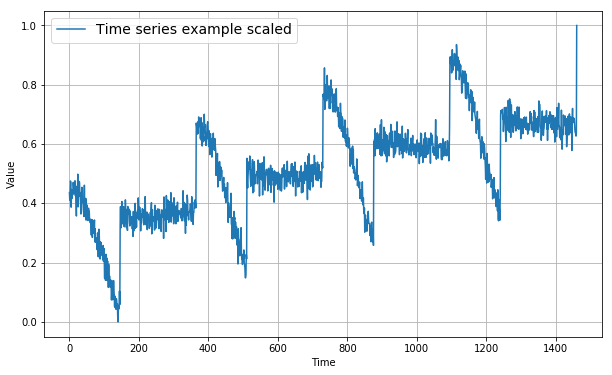

In [3]:
# Define the time series
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * (np.sqrt(time))

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

# The time series
time = np.arange(4 * 365 + 1)
baseline = 10
series = baseline + trend(time,0.5) + white_noise(time, noise_level=1, seed=0) + seasonality(time, period=365, amplitude=10, phase=0)
# Normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(series.reshape(-1,1))
series = scaler.transform(series.reshape(-1,1))[0:,0]
#Plot
plt.figure(figsize=(10, 6))
plot_series(time, series, label='Time series example scaled')
plt.show()

In [4]:
def window_dataset(series, window_size, batch_size=32, shuffle_buffer_size=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [5]:
# Train and validation split
x_train = time[:1000]
y_train = series[:1000]
x_val = time[1000:]
y_val = series[1000:]
# Train and val sets
window_size = 30
train_set = window_dataset(y_train, window_size=30, batch_size=128) 
val_set = window_dataset(y_val, window_size=30, batch_size=128)

In [6]:
# Model fitting: linear model
model =  tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.SimpleRNN(units=100),
    tf.keras.layers.Dense(units=1),
    #tf.keras.layers.Lambda(lambda x: x * 200.0)
])
model.compile(loss=tf.keras.losses.Huber(),
             optimizer='adam',
             metrics=['mae'])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=200, validation_data=val_set,callbacks=[early_stopping])

Epoch 1/200
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
8/8 [==============================] - 3s 410ms/step - loss: 0.0233 - mae: 0.1737 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/200
8/8 [==============================] - 1s 79ms/step - loss: 0.0038 - mae: 0.0702 - val_loss: 0.0096 - val_mae: 0.1259
Epoch 3/200
8/8 [==============================] - 1s 77ms/step - loss: 0.0029 - mae: 0.0579 - val_loss: 0.0014 - val_mae: 0.0397
Epoch 4/200
8/8 [==============================] - 1s 77ms/step - loss: 0.0018 - mae: 0.0427 - val_loss: 0.0018 - val_mae: 0.0400
Epoch 5/200
8/8 [==============================] - 1s 80ms/step - loss: 0.0013 - mae: 0.0363 - val_loss: 0.0017 - val_mae: 0.0417
Epoch 6/200
8/8 [==============================] - 1s 82ms/step - loss: 0.0012 - mae: 0.0337 - val_loss: 0.0012 - val_mae: 0.0326
Epoch 7/200
8/8 [==============================] - 1s 79ms/step - loss: 0.0011 - mae: 0.0322 - val_loss: 0.0012 - val

0.0019748325


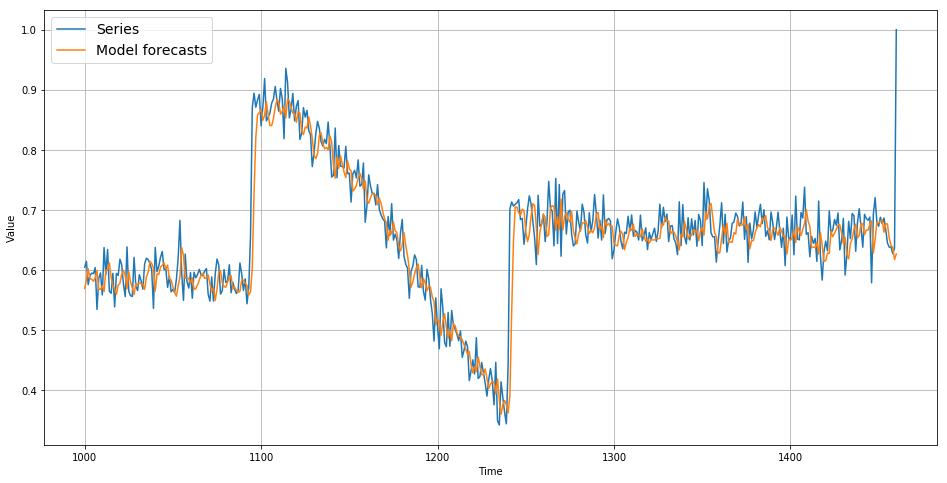

In [9]:
forecasts = model_forecast(model, series[1000-window_size:-1], window_size=window_size)[:,0]
plt.figure(figsize=(16,8))
plot_series(x_val, y_val, label='Series')
plot_series(x_val, forecasts, label='Model forecasts')
print(tf.keras.metrics.mean_squared_error(y_val, forecasts).numpy())

1096
-0.05186383322739552
0.31137242156446
0.11361671345272492


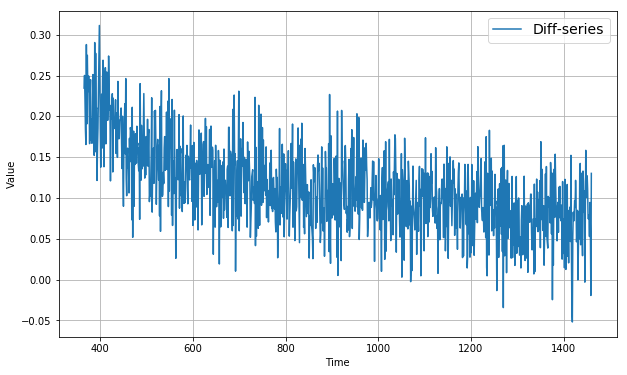

In [28]:
# Differencing
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10,6))
plot_series(diff_time, diff_series, label='Diff-series')
print(len(diff_series))

# Train and validation split for diff data
diff_y_train = diff_series[:1000-365]
diff_y_val = diff_series[1000-365:]
# Train and val sets
window_size = 30
diff_train_set = window_dataset(diff_y_train, window_size=30, batch_size=128) 
diff_val_set = window_dataset(diff_y_val, window_size=30, batch_size=128)
print(diff_series.min())
print(diff_series.max())
scale =  diff_series.mean()#diff_series.max()-diff_series.min()
print(scale)

In [29]:
# Train model on differenced data
model2 =  tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.SimpleRNN(units=100, return_sequences=True),
    tf.keras.layers.SimpleRNN(units=100),
    tf.keras.layers.Dense(units=1),
])
model2.compile(loss=tf.keras.losses.Huber(),
             optimizer='adam',
             metrics=['mae'])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=80)
model2.fit(diff_train_set, epochs=200, validation_data=diff_val_set,
           callbacks=[early_stopping, model_checkpoint])

Epoch 1/200
5/5 [==============================] - 4s 835ms/step - loss: 0.0897 - mae: 0.3839 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/200
5/5 [==============================] - 1s 144ms/step - loss: 0.0110 - mae: 0.1341 - val_loss: 0.0050 - val_mae: 0.0789
Epoch 3/200
5/5 [==============================] - 1s 138ms/step - loss: 0.0091 - mae: 0.1047 - val_loss: 0.0042 - val_mae: 0.0756
Epoch 4/200
5/5 [==============================] - 1s 134ms/step - loss: 0.0054 - mae: 0.0839 - val_loss: 0.0019 - val_mae: 0.0477
Epoch 5/200
5/5 [==============================] - 1s 136ms/step - loss: 0.0029 - mae: 0.0631 - val_loss: 0.0015 - val_mae: 0.0440
Epoch 6/200
5/5 [==============================] - 1s 130ms/step - loss: 0.0017 - mae: 0.0487 - val_loss: 0.0031 - val_mae: 0.0662
Epoch 7/200
5/5 [==============================] - 1s 139ms/step - loss: 0.0018 - mae: 0.0455 - val_loss: 0.0011 - val_mae: 0.0393
Epoch 8/200
5/5 [==============================] - 1s 140ms/step - loss: 0.

In [30]:
model2 = tf.keras.models.load_model("my_checkpoint.h5")

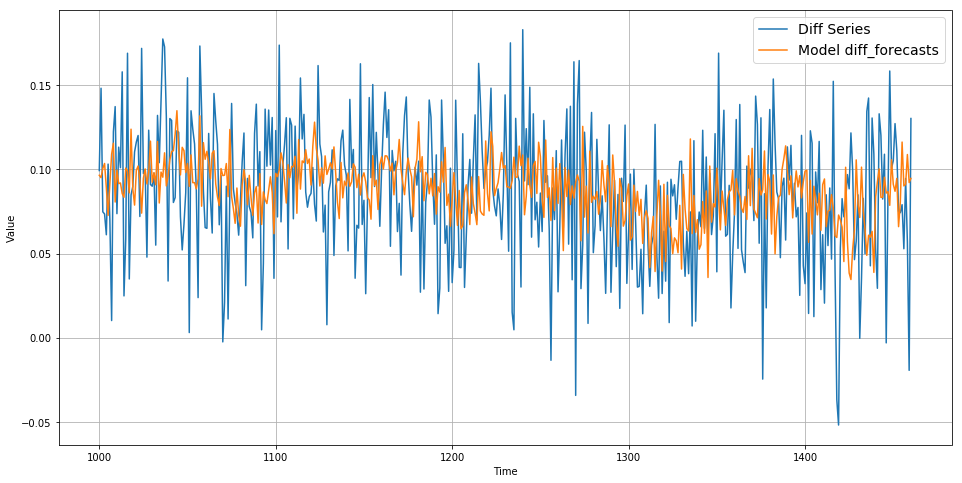

In [31]:
forecasts_diff = model_forecast(model2, diff_series[1000-365-window_size:-1], window_size=window_size)[:,0]
plt.figure(figsize=(16,8))
plot_series(x_val, diff_y_val, label='Diff Series')
plot_series(x_val, forecasts_diff, label='Model diff_forecasts')

0.001720543646953307


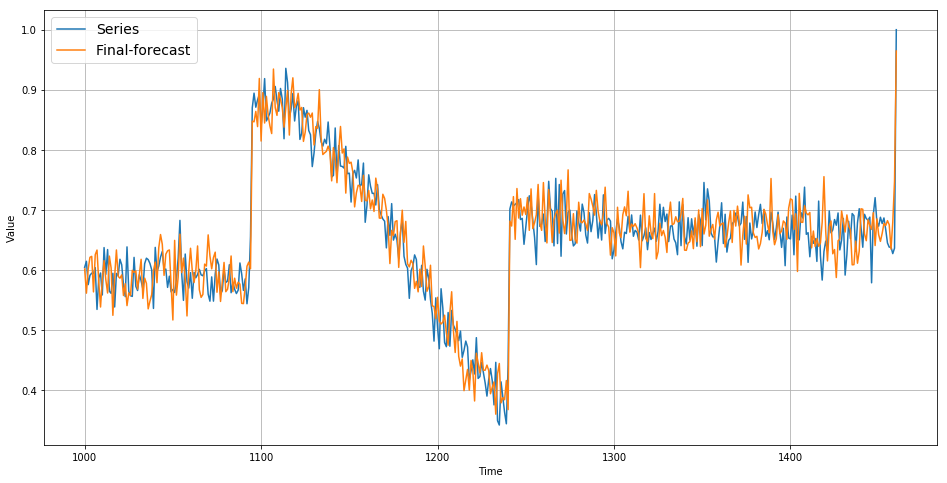

In [32]:
# De-differencing
final_forecast = forecasts_diff + series[1000-365:1000-365+len(y_val)]
plt.figure(figsize=(16, 8))
plot_series(x_val, y_val, label="Series")
plot_series(x_val, final_forecast, label="Final-forecast")
print(tf.keras.metrics.mean_squared_error(y_val, final_forecast).numpy())